# Notebook 3: Model Setup and Evaluation

## Introduction

In this notebook, we will use the dataset prepared in notebook 2 to begin the modelling process to predict the rating of the restaurant. 

## Methodology

In this notebook, we will need to prepare our review text data to make it ready for machine learning. 



## Data Preprocessing

### Import Libraries
We begin by importing all the libraries required to run this notebook.

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.sparse import csr_matrix

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


from xgboost import XGBRegressor


# the python string package has a helpful punctuation list
import string

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import gensim
from gensim.utils import simple_preprocess

import joblib


# Define some default visualizaiton display properties

# Ensure plots are always centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/allistaircota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allistaircota/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read in Dataset

We now read in the review dataset that was cleaned in Notebook 2.

In [2]:
df = pd.read_csv('../data/review_data_cleaned.csv')
df.head()

,date,latitude,longitude,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,Specialty Food,stars,useful,funny,cool,text,average_fans_per_user,reviews_per_week,repeat_customers,number_of_branches
0,2016-03-07 17:58:53,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,4,0,0,0,Pizza here is delicious. I tried it once a few...,4.717949,0.057097,0,1
1,2014-05-10 11:35:46,42.475805,-70.926544,201,1,1,0,0,1,2,...,0,5,0,0,0,Delicious! My co-workers came back from lunch...,2.715596,0.353864,12,3
2,2014-07-18 14:36:15,42.520691,-70.894220,141,1,1,0,1,1,1,...,0,5,0,0,1,I really miss this place. I used to work in S...,8.937500,0.190339,2,1
3,2010-01-10 17:33:51,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,4,1,0,0,love this place! really good pizza and probabl...,4.717949,0.057097,0,1
4,2012-02-13 05:53:37,42.540409,-71.153318,66,1,1,1,1,1,1,...,0,2,5,1,0,"Saw that they won a ""Sandie"" award from Phanto...",3.352941,0.109753,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 47 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   date                        1364840 non-null  object 
 1   latitude                    1364840 non-null  float64
 2   longitude                   1364840 non-null  float64
 3   review_count                1364840 non-null  int64  
 4   is_open                     1364840 non-null  int64  
 5   RestaurantsGoodForGroups    1364840 non-null  int64  
 6   HasTV                       1364840 non-null  int64  
 7   GoodForKids                 1364840 non-null  int64  
 8   RestaurantsTakeOut          1364840 non-null  int64  
 9   RestaurantsPriceRange2      1364840 non-null  int64  
 10  RestaurantsReservations     1364840 non-null  int64  
 11  RestaurantsAttire           1364840 non-null  object 
 12  RestaurantsDelivery         1364840 non-null  int64  
 1

### Converting Date Column

We can see that the `date` column is of an object data type. It would be more convenient, if we could extract the individual components of the date as separate numeric columns (e.g. year, month, etc., of the review). To do this, we first convert the `date` column to a `datetime` format and then extract the components of interest. 

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.insert(loc=0, column='Year', value=df['date'].dt.year)
df.insert(loc=1, column='Month', value=df['date'].dt.month)
df.insert(loc=2, column='Day', value=df['date'].dt.day)
df.insert(loc=3, column='Day of Week', value=df['date'].dt.weekday)
df.insert(loc=4, column='Hour', value=df['date'].dt.hour)
df.insert(loc=5, column='Minute', value=df['date'].dt.minute)
df.drop('date', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 52 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

We have successfully converted the date components to separate integer columns.

### Ordering the columns

We will be using a column transformer later in this notebook to apply specific transformations to certain columns based on their data type and the information that each contains. Hence, it will be convenient to reorder the columns in a convenient order, based on the order the column transformations will be applied. For now, we will move all columns of the `object` data type to the end of the data frame. 

In [5]:
# Get  columns whose data type is object
object_columns = df.dtypes[df.dtypes == 'object']

# Put the object column names into a list
object_columns = object_columns.index.tolist()
object_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi', 'text']

In [6]:
# Keep the object type columns in a temporary data frame
temp_df = df[object_columns]
temp_df

,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,casual,average,none,no,I really miss this place. I used to work in S...
3,casual,average,none,free,love this place! really good pizza and probabl...
4,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."
...,...,...,...,...,...
1364835,casual,average,beer_and_wine,no,We need restaurants like this to remind us whe...
1364836,casual,average,beer_and_wine,no,Food is good but small portions ! A bit overly...
1364837,casual,average,beer_and_wine,no,I had orders the pasta carbonara for a pick up...
1364838,casual,average,full_bar,no,"As I said, my family and I gave the Jury Room ..."


In [7]:
# Merge the data frame without object columns with the temporary data frame

df = pd.concat([df.drop(columns = object_columns), temp_df], axis=1)
df.head()


,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,cool,average_fans_per_user,reviews_per_week,repeat_customers,number_of_branches,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0,4.717949,0.057097,0,1,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,2014,5,10,5,11,35,42.475805,-70.926544,201,1,...,0,2.715596,0.353864,12,3,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,2014,7,18,4,14,36,42.520691,-70.894220,141,1,...,1,8.937500,0.190339,2,1,casual,average,none,no,I really miss this place. I used to work in S...
3,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0,4.717949,0.057097,0,1,casual,average,none,free,love this place! really good pizza and probabl...
4,2012,2,13,0,5,53,42.540409,-71.153318,66,1,...,0,3.352941,0.109753,2,1,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 52 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

### Define X and y

We are now ready to define our independent variable array `X` and our dependent variable `y`. Our dependent variable is the number of stars (i.e. the `stars` column).

In [9]:
X = df.drop(['stars'], axis=1)
X.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,cool,average_fans_per_user,reviews_per_week,repeat_customers,number_of_branches,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0,4.717949,0.057097,0,1,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,2014,5,10,5,11,35,42.475805,-70.926544,201,1,...,0,2.715596,0.353864,12,3,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,2014,7,18,4,14,36,42.520691,-70.894220,141,1,...,1,8.937500,0.190339,2,1,casual,average,none,no,I really miss this place. I used to work in S...
3,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0,4.717949,0.057097,0,1,casual,average,none,free,love this place! really good pizza and probabl...
4,2012,2,13,0,5,53,42.540409,-71.153318,66,1,...,0,3.352941,0.109753,2,1,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."


In [10]:
y = df['stars']
y.head()

0    4
1    5
2    5
3    4
4    2
Name: stars, dtype: int64

It would be good to view the distribution of our dependent variable.

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_4373/65967193.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


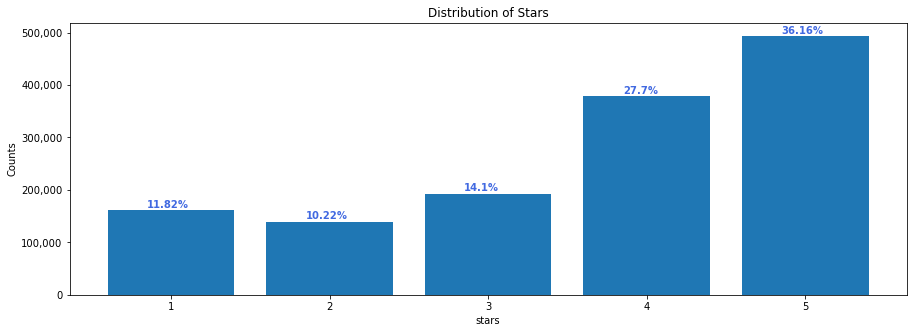

In [11]:
plt.figure(figsize=(15,5))
plt.bar(y.value_counts().sort_index().index.astype('str'),
        y.value_counts().sort_index())
plt.title('Distribution of Stars')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y.value_counts().sort_index()):
    axes.text(i-0.15, j + 5000, str(round(j/X.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

Our distribution is left skewed. However, we do have a reasonable distribution across all the possible number of ratings.

### Checking Correlation of Numeric Columns with Rating

In [12]:
def correlation_coeff(X, y):
    
    correlation_df = pd.DataFrame(columns=['Variable', 'Correlation Coefficient', 'p-value'])
    
    for column in X.columns:
        corr_coef, p_value = stats.pearsonr(X[column], y)
        correlation_df = correlation_df.append({'Variable': column,
                                                'Correlation Coefficient': corr_coef,
                                                'p-value': p_value}, ignore_index=True)
        correlation_df.sort_values(by='p-value', ascending=False, inplace=True)
    
    return correlation_df

In [13]:
correlation_coeff(X.drop(columns=object_columns), y)

,Variable,Correlation Coefficient,p-value
0,Day,0.000464,5.878830e-01
1,Minute,-0.000980,2.524647e-01
2,longitude,0.001961,2.198227e-02
3,average_fans_per_user,0.002826,9.624271e-04
4,GoodForKids,0.002975,5.091648e-04
5,OutdoorSeating,-0.004986,5.697669e-09
6,Salad,0.005149,1.792507e-09
7,Month,-0.005621,5.155104e-11
8,latitude,0.006700,4.961500e-15
9,American (New),-0.009541,7.422744e-29


### Checking for Multicollinearity

In [14]:
def corr_matrix_heatmap(X):
    plt.figure(figsize=(20,15))
    corr_matrix=X.corr()
    mask = np.triu(np.ones_like(corr_matrix))

    sns.heatmap(corr_matrix, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
    plt.show()

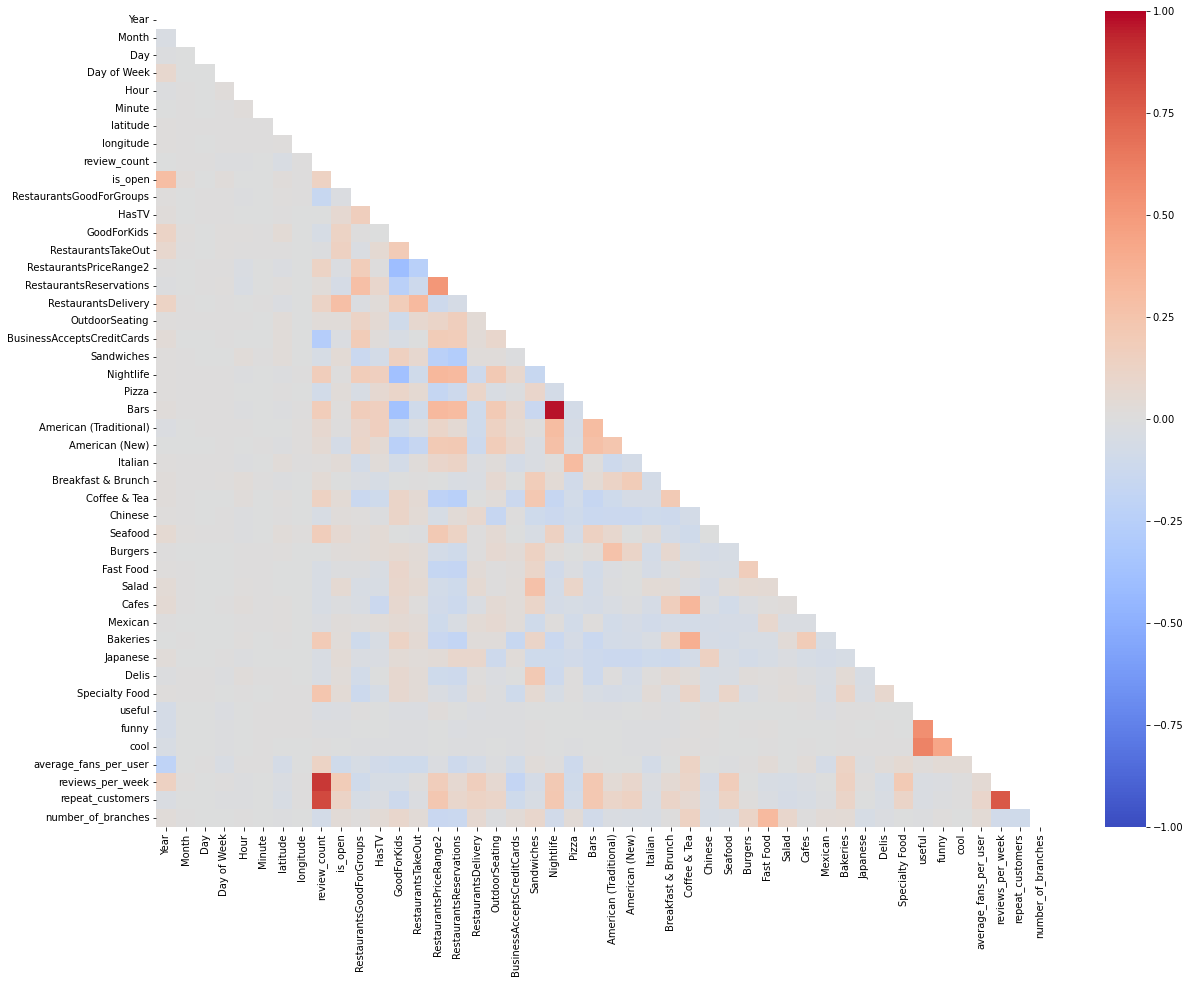

In [15]:
corr_matrix_heatmap(X)

In [16]:
print(f"{stats.pearsonr(X['Bars'], X['Nightlife'])}")
print(f" Correlation of Bars with Stars {stats.pearsonr(X['Bars'], y)}")
print(f" Correlation of Nightlife with Stars {stats.pearsonr(X['Nightlife'], y)}")


(0.9756265437729745, 0.0)
 Correlation of Bars with Stars (-0.01024077266579386, 5.4705721859526906e-33)
 Correlation of Nightlife with Stars (-0.01522788913121939, 8.268286162245917e-71)


In [17]:
X.drop(['Nightlife', 'review_count'], axis=1, inplace=True)

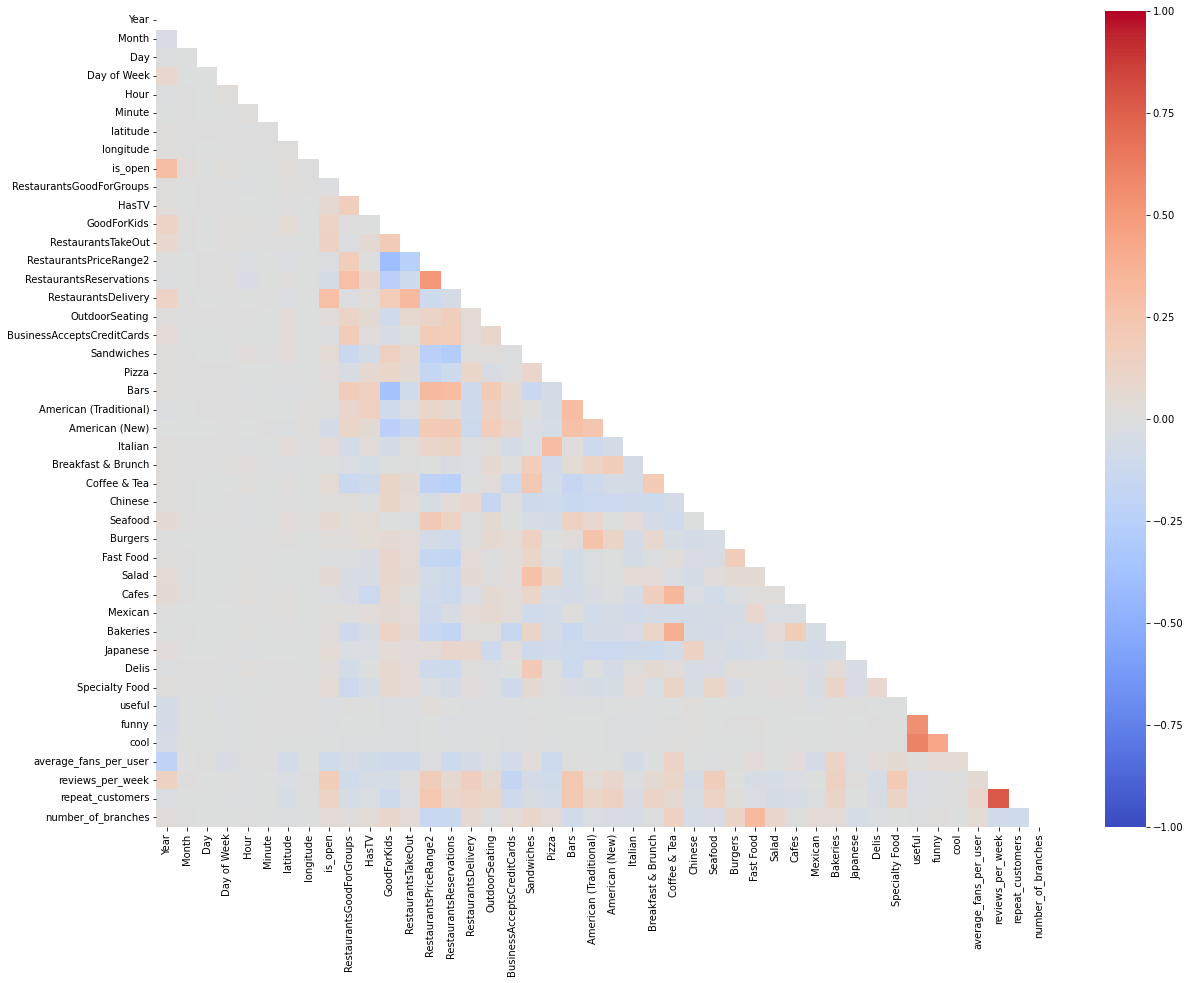

In [18]:
corr_matrix_heatmap(X)

In [19]:
stats.pearsonr(X['reviews_per_week'], X['repeat_customers'])

(0.7803776845662647, 0.0)

### Sampling the Data

Due to the large dataset (1.3 million reviews) which includes text data, and computing hardware limitations, we will subsample our dataset so that the dataset is more manageable more model training and evaluation. We will use the `resample` method from Scikit-Learn, sampling without replacement, and stratifying based on y. For this project, we will utilize around 13,000 reviews (~1% of the original dataset).

In [20]:
X_sampled, y_sampled = resample(X, y, random_state=0, 
                                    n_samples = 0.01*X.shape[0],
                                    replace=False, stratify=y)

In [21]:
print(f'X_sampled shape: {X_sampled.shape}')
print(f'y_sampled shape: {y_sampled.shape}')

X_sampled shape: (13648, 49)
y_sampled shape: (13648,)


Our sampled dataset has 13,648 rows and 50 columns. Let's take a look at the distribution of our dependent variable in this sample.

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_4373/1967618503.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


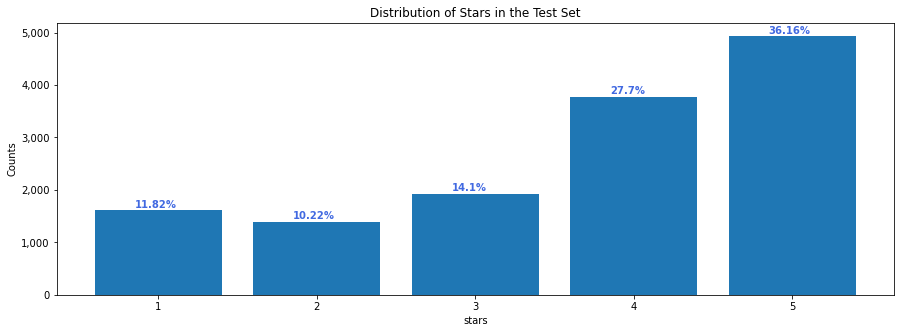

In [22]:
plt.figure(figsize=(15,5))
plt.bar(y_sampled.value_counts().sort_index().index.astype('str'),
        y_sampled.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y_sampled.value_counts().sort_index()):
    axes.text(i-0.15, j + 50, str(round(j/X_sampled.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

The stratification worked as intended, since our dependent variable distribution in this sample is very similar to its distribution in the overall dataset.

In [23]:
X_sampled.columns

Index(['Year', 'Month', 'Day', 'Day of Week', 'Hour', 'Minute', 'latitude',
       'longitude', 'is_open', 'RestaurantsGoodForGroups', 'HasTV',
       'GoodForKids', 'RestaurantsTakeOut', 'RestaurantsPriceRange2',
       'RestaurantsReservations', 'RestaurantsDelivery', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'Sandwiches', 'Pizza', 'Bars',
       'American (Traditional)', 'American (New)', 'Italian',
       'Breakfast & Brunch', 'Coffee & Tea', 'Chinese', 'Seafood', 'Burgers',
       'Fast Food', 'Salad', 'Cafes', 'Mexican', 'Bakeries', 'Japanese',
       'Delis', 'Specialty Food', 'useful', 'funny', 'cool',
       'average_fans_per_user', 'reviews_per_week', 'repeat_customers',
       'number_of_branches', 'RestaurantsAttire', 'NoiseLevel', 'Alcohol',
       'WiFi', 'text'],
      dtype='object')

## Modelling Setup

### Defining Train and Test Sets

We begin model setup by defining our train and test sets. Note that since we have a relatively smaller dataset to work with (13k rows), we should make sure to leave enough samples in our test set to avoid overfitting to the train set. Hence we will opt for an 80% train - 20% test split.

In [24]:
# Splitting out 20% for test set
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size = 0.2, stratify=y_sampled, random_state=0)

print(f'Shape of X_train: {X_train.shape}. Shaper of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}. Shaper of y_test: {y_test.shape}')

Shape of X_train: (10918, 49). Shaper of y_train: (10918,)
Shape of X_test: (2730, 49). Shaper of y_test: (2730,)


Let's visualize the distributions of our dependent variable from both train and test sets, to ensure we have similar distributions to our original dataset.

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_4373/825166854.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


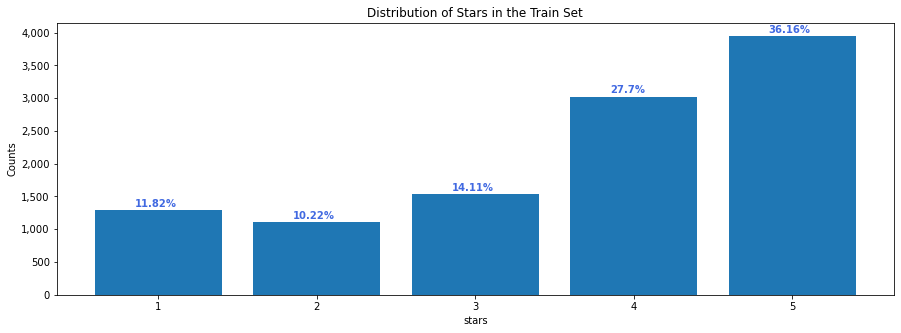

In [25]:
plt.figure(figsize=(15,5))
plt.bar(y_train.value_counts().sort_index().index.astype('str'),
        y_train.value_counts().sort_index())
plt.title('Distribution of Stars in the Train Set')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y_train.value_counts().sort_index()):
    axes.text(i-0.15, j + 50, str(round(j/X_train.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.show()

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_4373/2988498762.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


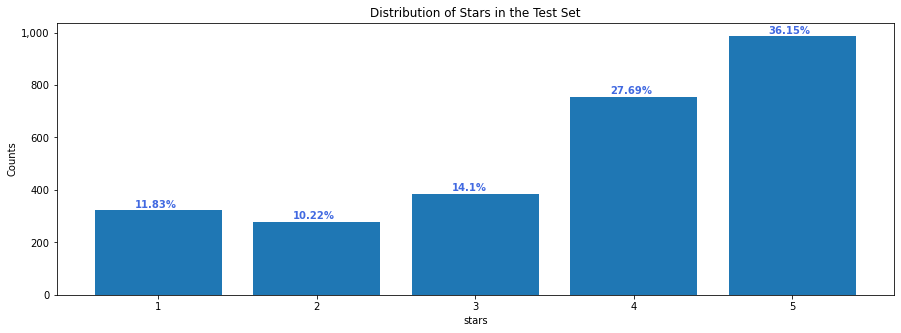

In [26]:
plt.figure(figsize=(15,5))
plt.bar(y_test.value_counts().sort_index().index.astype('str'),
        y_test.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y_test.value_counts().sort_index()):
    axes.text(i-0.15, j + 10, str(round(j/X_test.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.show()

We see no major difference between in the dependent variable in both train and test sets when compared to the original dataset. 

### Custom Scoring Functions

Some regression models such as linear regression can make predictions which are lower or greater than the values present in the dataset. Since we know our ratings cannot be below 1 stars nor can they be greater than 5 stars, we need to define a custom function called `bound_predict` that bounds all predictions to within the allowed range. In addition, we need to define a custom scorer function to ensure that Scikit-Learn models such as `cross_validate` and `GridSearchCV` will apply the `bound_predict` method to each model's predictions before calculating the appropriate score. We will pick the model with the best mean absolute error, but we will also monitor the $R^{2}$ score as well to evaluate the quality of the model's fit.

In [27]:
def bound_predict(y_pred):
    y_pred = np.where(y_pred > 5, 5, y_pred)
    y_pred = np.where(y_pred < 1, 1, y_pred)
    return y_pred

In [28]:
def custom_mae_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return mean_absolute_error(y_true, y_pred)

def custom_r2_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return r2_score(y_true, y_pred)

custom_mae_scorer = make_scorer(custom_mae_scorer_func, greater_is_better=False)
custom_r2_scorer = make_scorer(custom_r2_scorer_func, greater_is_better=True)

scorer = {'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
          'custom_r2_scorer': make_scorer(custom_r2_scorer_func, greater_is_better=True)}

### Defining Pipeline and Word Encoding Transformers

In [29]:
numeric_columns = X_train.dtypes[df.dtypes != 'object'].index.to_list()
numeric_columns

['Year',
 'Month',
 'Day',
 'Day of Week',
 'Hour',
 'Minute',
 'latitude',
 'longitude',
 'is_open',
 'RestaurantsGoodForGroups',
 'HasTV',
 'GoodForKids',
 'RestaurantsTakeOut',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'OutdoorSeating',
 'BusinessAcceptsCreditCards',
 'Sandwiches',
 'Pizza',
 'Bars',
 'American (Traditional)',
 'American (New)',
 'Italian',
 'Breakfast & Brunch',
 'Coffee & Tea',
 'Chinese',
 'Seafood',
 'Burgers',
 'Fast Food',
 'Salad',
 'Cafes',
 'Mexican',
 'Bakeries',
 'Japanese',
 'Delis',
 'Specialty Food',
 'useful',
 'funny',
 'cool',
 'average_fans_per_user',
 'reviews_per_week',
 'repeat_customers',
 'number_of_branches']

In [30]:
categorical_columns = X_train.drop('text', axis=1).dtypes[df.dtypes == 'object'].index.to_list()
categorical_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi']

In [31]:
def tokenizer_prep(sentence):
    # remove punctuation and set to lower case
    english_stop_words = stopwords.words('english')
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    return english_stop_words, listofwords


def tokenizer_stemming(sentence):
    stemmer = PorterStemmer()
    english_stop_words, listofwords = tokenizer_prep(sentence) 
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in english_stop_words) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

def tokenizer_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    english_stop_words, listofwords = tokenizer_prep(sentence) 
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in english_stop_words) and (word!=''):
            # Lematized words
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words


In [32]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    '../data/lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False
)

In [33]:
def sentence2vec(text):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

def sent2vec_col_trans(col):
    sentence_embedding = col.apply(sentence2vec)
    return np.array(sentence_embedding.tolist())

In [34]:
def define_col_trans(input_text, vectorizer):
    col_trans = ColumnTransformer([
        ('numeric', 'passthrough', numeric_columns),
        ('category', OneHotEncoder(drop='first'), categorical_columns),
        (input_text, vectorizer, 'text')
    ])
    
    return col_trans

In [35]:
def convert_to_array(sparse_matrix):
#     return sparse_matrix.toarray()
    
    if type(sparse_matrix) == csr_matrix:
    
        return sparse_matrix.toarray()
    
    else:
        return sparse_matrix

In [314]:
bow_ct = define_col_trans('bow_ct', CountVectorizer(stop_words='english', min_df=20))
bow_stem_ct = define_col_trans('bow_stem_ct', CountVectorizer(tokenizer=tokenizer_stemming, min_df=20))
bow_lem_ct = define_col_trans('bow_lem_ct', CountVectorizer(tokenizer=tokenizer_lemmatizer, min_df=20))
tfidf_ct = define_col_trans('tfidf_ct', TfidfVectorizer(stop_words='english', min_df=20))
tfidf_stem_ct = define_col_trans('tfidf_stem_ct', TfidfVectorizer(min_df=20, tokenizer=tokenizer_stemming))
tfidf_lem_ct = define_col_trans('tfidf_lem_ct', TfidfVectorizer(min_df=20, tokenizer=tokenizer_lemmatizer))
sent2vec = define_col_trans('sent2vec', FunctionTransformer(sent2vec_col_trans))

vectorizer_list = [bow_ct, bow_stem_ct, bow_lem_ct, tfidf_ct, tfidf_stem_ct, tfidf_lem_ct, sent2vec]

In [315]:
temp_df = bow_ct.fit_transform(X_train)
temp_df.shape

(10918, 3000)

In [316]:
temp_df = sent2vec.fit_transform(X_train)
temp_df.shape

(10918, 352)

### Dummy Model

In [39]:
# dummy_reg = DummyRegressor(strategy="mean")
# dummy_reg.fit(X_test_scaled_1a, y_test)

In [40]:
# prediction = dummy_reg.predict(X_test_scaled_1a)
# mean_absolute_error(y_test, prediction)

In [41]:
# custom_mae_scorer_func(y_test, prediction)

## Model Evaluation

### Linear Regression

In [317]:
%%time

pipeline = Pipeline([
    ('col_trans', bow_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler())
])

X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

CPU times: user 1.32 s, sys: 308 ms, total: 1.63 s
Wall time: 1.64 s


In [318]:
X_train_prepared.shape

(10918, 3000)

In [44]:
X_test.shape

(2730, 49)

#### L2 Regularization

In [45]:
%%time

scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

for power in range(-4, 4, 1):
    alpha = 10**power
    
   
    cv_scores = cross_validate(Ridge(alpha=alpha), X_train_prepared, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'alpha': alpha,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores

CPU times: user 5min 52s, sys: 26.4 s, total: 6min 18s
Wall time: 36.5 s


,alpha,MAE,R-squared
0,0.0001,0.764183,0.454707
1,0.0010,0.764124,0.454821
2,0.0100,0.763700,0.455680
3,0.1000,0.758308,0.465165
4,1.0000,0.730414,0.513477
5,10.0000,0.709917,0.558614
6,100.0000,0.809419,0.458669
7,1000.0000,1.020846,0.190547


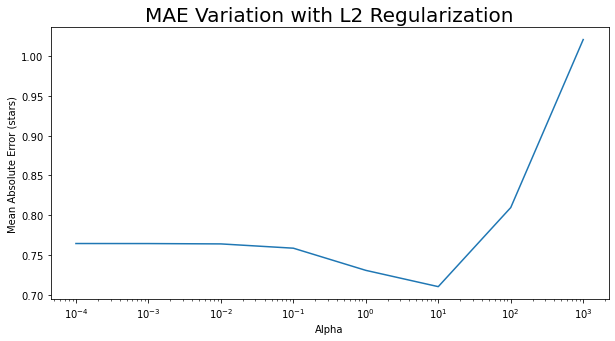

In [46]:
plt.figure(figsize=(10,5))
plt.plot(scores['alpha'], scores['MAE'])
plt.title('MAE Variation with L2 Regularization', fontsize=20)
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error (stars)')
plt.xscale('log')
plt.show()

#### L1 Regularization

In [47]:
%%time

scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

for alpha in [0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 1, 10, 100]:
       
    cv_scores = cross_validate(Lasso(alpha=alpha), X_train_prepared, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'alpha': alpha,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores

CPU times: user 7min 55s, sys: 57.1 s, total: 8min 52s
Wall time: 2min 31s


,alpha,MAE,R-squared
0,0.0001,0.714192,0.536529
1,0.0005,0.707115,0.562267
2,0.0010,0.732078,0.538061
3,0.0100,0.966356,0.262635
4,0.0500,1.155200,0.000151
5,0.1000,1.155397,-0.000224
6,1.0000,1.155397,-0.000224
7,10.0000,1.155397,-0.000224
8,100.0000,1.155397,-0.000224


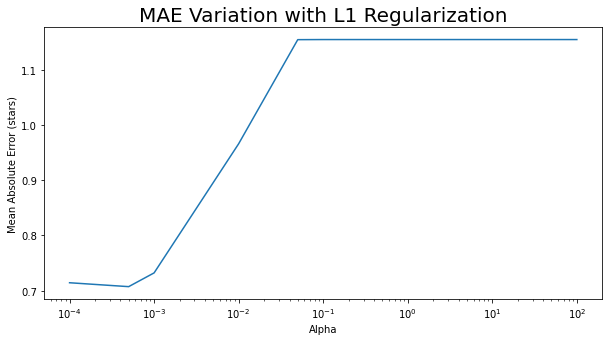

In [48]:
plt.figure(figsize=(10,5))
plt.plot(scores['alpha'], scores['MAE'])
plt.title('MAE Variation with L1 Regularization', fontsize=20)
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error (stars)')
plt.xscale('log')
plt.show()

#### Pipeline and Model Optimization Using GridSearchCV

In [49]:
linreg_pipeline = Pipeline([
    ('col_trans', bow_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('min-max-scaler', MinMaxScaler()),
    ('model', Ridge())
])


param_grid = [
                {
                    'model': [LinearRegression()],
                    'col_trans': vectorizer_list
                },
                {
                    'model': [Ridge()],
                    'col_trans': vectorizer_list,
                    'model__alpha': [1, 10, 100]
                },
                {
                    'model': [Lasso()],
                    'col_trans': vectorizer_list,
                    'model__alpha': [0.0001, 0.0005, 0.0001]
                }] 


linreg_grid_search = GridSearchCV(linreg_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4)

In [50]:
%%time
linreg_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.232e+01, tolerance: 1.631e+00
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.598e+00, tolerance: 1.618e+00
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.877e+00, tolerance: 1.617e+00
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.062e+01, tolerance: 1.630e+00
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.641e+00, tolerance: 1.629e+00
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.232e+01, tolerance: 1.631e+00
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.598e+00, tolerance: 1.618e+00
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.877e+00, tolerance: 1.617e+00
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.062e+01, tolerance: 1.630e+00
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.641e+00, tolerance: 1.629e+00
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

In [51]:
linreg_grid_search.best_params_

{'col_trans': ColumnTransformer(transformers=[('numeric', 'passthrough',
                                  ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                   'Minute', 'latitude', 'longitude', 'is_open',
                                   'RestaurantsGoodForGroups', 'HasTV',
                                   'GoodForKids', 'RestaurantsTakeOut',
                                   'RestaurantsPriceRange2',
                                   'RestaurantsReservations',
                                   'RestaurantsDelivery', 'OutdoorSeating',
                                   'BusinessAcceptsCreditCards', 'Sandwiches',
                                   'Pizza', 'Bars', 'American (Traditional)',
                                   'American (New)', 'Italian',
                                   'Breakfast & Brunch', 'Coffee & Tea',
                                   'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                 ('cate

The best pipeline returned by the Linear Regression Grid Search was a TF-IDF Vectorizer without stemming nor lemmatization with a Lasso Regression model with an alpha value of 0.0005.

In [126]:
type(linreg_grid_search.cv_results_['params'][0]['model']) == LinearRegression

True

In [106]:
linreg_grid_search.cv_results_['params'][0]['col_trans'].get_params()['transformers'][2][0]

'bow_ct'

In [111]:
linreg_grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_col_trans', 'param_model', 'param_model__alpha', 'params', 'split0_test_custom_mae_scorer', 'split1_test_custom_mae_scorer', 'split2_test_custom_mae_scorer', 'split3_test_custom_mae_scorer', 'split4_test_custom_mae_scorer', 'mean_test_custom_mae_scorer', 'std_test_custom_mae_scorer', 'rank_test_custom_mae_scorer', 'split0_test_custom_r2_scorer', 'split1_test_custom_r2_scorer', 'split2_test_custom_r2_scorer', 'split3_test_custom_r2_scorer', 'split4_test_custom_r2_scorer', 'mean_test_custom_r2_scorer', 'std_test_custom_r2_scorer', 'rank_test_custom_r2_scorer'])

In [118]:
linreg_grid_search.cv_results_['mean_test_custom_mae_scorer']

array([-0.75039233, -0.75443946, -0.75217708, -0.66848244, -0.67571587,
       -0.67946519, -0.7196864 , -0.72964231, -0.71551384, -0.80632288,
       -0.74101765, -0.7340573 , -0.82814843, -0.73690077, -0.73135075,
       -0.82644643, -0.65291945, -0.64030023, -0.75829842, -0.66655571,
       -0.66035606, -0.78522091, -0.66773341, -0.65945786, -0.78754386,
       -0.72105351, -0.73155249, -0.80054235, -0.71658714, -0.71006256,
       -0.71658714, -0.73035682, -0.72829869, -0.73035682, -0.72456135,
       -0.72373918, -0.72456135, -0.63850627, -0.63766529, -0.63850627,
       -0.65730315, -0.65770902, -0.65730315, -0.6553502 , -0.65539389,
       -0.6553502 , -0.72099501, -0.73110545, -0.72099501])

In [127]:
temp_df = pd.DataFrame(columns=['Regularization', 'Vectorizer', 'Alpha', 'MAE', 'R2'])

for item in linreg_grid_search.cv_results_['params']:
    i = linreg_grid_search.cv_results_['params'].index(item)
    #model_type = type(item['model'])
    if type(item['model']) == Ridge:
        reg_type = 'L2 Regularization'
        
    elif type(item['model']) == Lasso:
        reg_type = 'L1 Regularization'
    
    else:
        reg_type = 'No Regularization'
    
    vectorizer = item['col_trans'].get_params()['transformers'][2][0]
    
    if reg_type == 'No Regularization':
        alpha = 0
    
    else:
        alpha = item['model__alpha']
    
    temp_df = temp_df.append({'Regularization': reg_type,
                              'Vectorizer': vectorizer,
                              'Alpha': alpha,
                              'MAE': -linreg_grid_search.cv_results_['mean_test_custom_mae_scorer'][i],
                              'R2': linreg_grid_search.cv_results_['mean_test_custom_r2_scorer'][i]},
                             ignore_index=True)
    
temp_df
        

,Regularization,Vectorizer,Alpha,MAE,R2
0,No Regularization,bow_ct,0,0.750392,0.481953
1,No Regularization,bow_stem_ct,0,0.754439,0.483881
2,No Regularization,bow_lem_ct,0,0.752177,0.486743
3,No Regularization,tfidf_ct,0,0.668482,0.575205
4,No Regularization,tfidf_stem_ct,0,0.675716,0.573304
5,No Regularization,tfidf_lem_ct,0,0.679465,0.568642
6,No Regularization,sent2vec,0,0.719686,0.545811
7,L2 Regularization,bow_ct,1,0.729642,0.516081
8,L2 Regularization,bow_ct,10,0.715514,0.551939
9,L2 Regularization,bow_ct,100,0.806323,0.461803


In [137]:
temp_df[temp_df['Regularization'].isin(['No Regularization', 'L2 Regularization'])]

,Regularization,Vectorizer,Alpha,MAE,R2
0,No Regularization,bow_ct,0,0.750392,0.481953
1,No Regularization,bow_stem_ct,0,0.754439,0.483881
2,No Regularization,bow_lem_ct,0,0.752177,0.486743
3,No Regularization,tfidf_ct,0,0.668482,0.575205
4,No Regularization,tfidf_stem_ct,0,0.675716,0.573304
5,No Regularization,tfidf_lem_ct,0,0.679465,0.568642
6,No Regularization,sent2vec,0,0.719686,0.545811
7,L2 Regularization,bow_ct,1,0.729642,0.516081
8,L2 Regularization,bow_ct,10,0.715514,0.551939
9,L2 Regularization,bow_ct,100,0.806323,0.461803


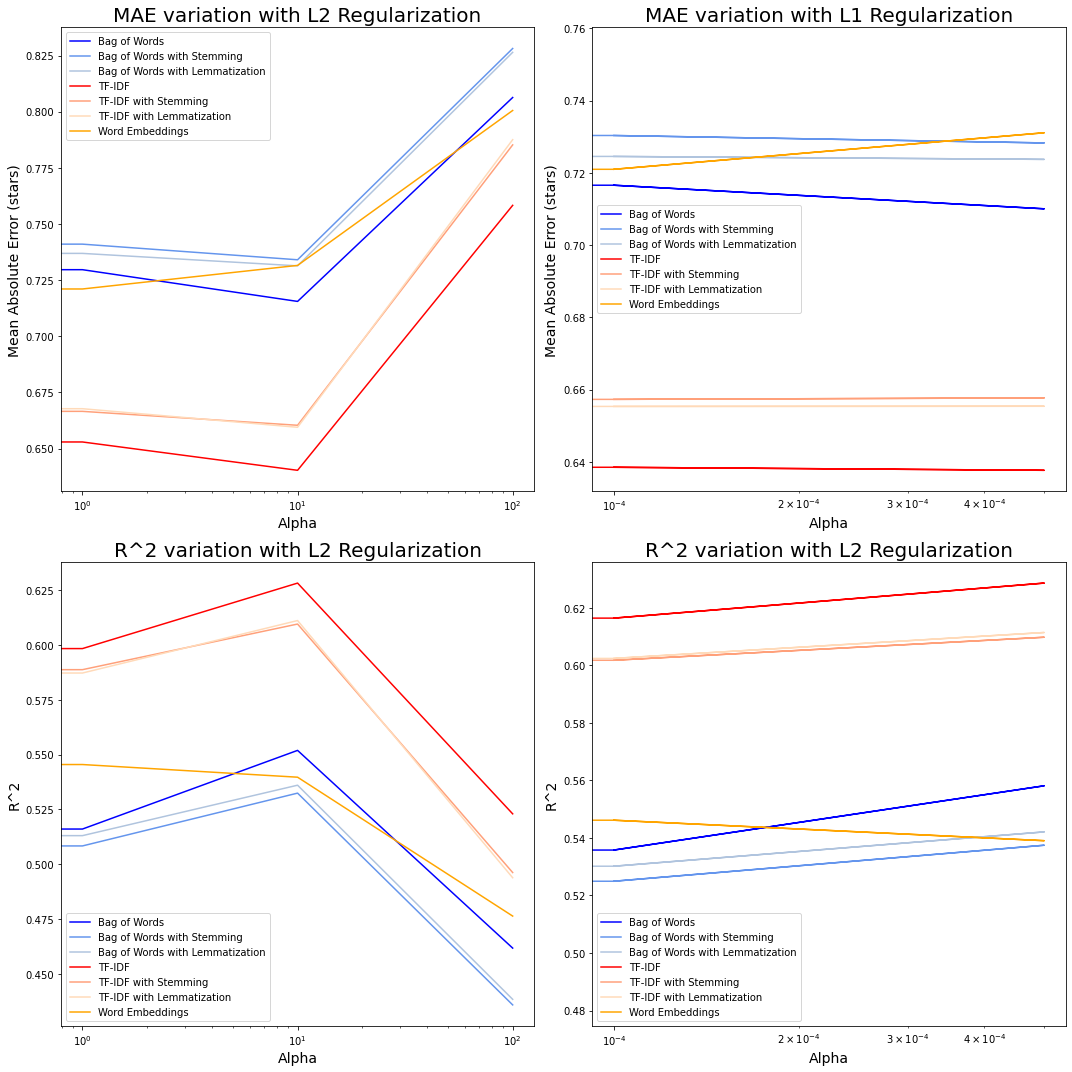

In [158]:
vectorizer_dict = {'bow_ct': {'descriptor': 'Bag of Words', 'color': 'blue'},
                   'bow_stem_ct': {'descriptor': 'Bag of Words with Stemming', 'color': 'cornflowerblue'},
                   'bow_lem_ct': {'descriptor': 'Bag of Words with Lemmatization', 'color': 'lightsteelblue'},
                   'tfidf_ct': {'descriptor': 'TF-IDF', 'color': 'red'},
                   'tfidf_stem_ct': {'descriptor': 'TF-IDF with Stemming', 'color': 'lightsalmon'},
                   'tfidf_lem_ct': {'descriptor': 'TF-IDF with Lemmatization', 'color': 'peachpuff'},
                   'sent2vec': {'descriptor': 'Word Embeddings','color': 'orange'}}



plt.subplots(2, 2, figsize=(15,15))

l2_df = temp_df[temp_df['Regularization'].isin(['No Regularization', 'L2 Regularization'])]

plt.subplot(2, 2, 1)
for vectorizer in l2_df['Vectorizer'].unique():
    vect_df = l2_df[l2_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['MAE'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('MAE variation with L2 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('Mean Absolute Error (stars)', fontsize=14)
    plt.legend()
    
plt.subplot(2, 2, 3)
for vectorizer in l2_df['Vectorizer'].unique():
    vect_df = l2_df[l2_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['R2'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('R^2 variation with L2 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('R^2', fontsize=14)
    plt.legend()
    
plt.subplot(2, 2, 2)
l1_df = temp_df[temp_df['Regularization'].isin(['No Regularization', 'L1 Regularization'])]

for vectorizer in l1_df['Vectorizer'].unique():
    vect_df = l1_df[l1_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['MAE'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('MAE variation with L1 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('Mean Absolute Error (stars)', fontsize=14)
    plt.legend()

plt.subplot(2, 2, 4)
for vectorizer in l1_df['Vectorizer'].unique():
    vect_df = l1_df[l1_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['R2'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('R^2 variation with L2 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('R^2', fontsize=14)
    plt.legend()


plt.tight_layout()
plt.show()

Now that we have tuned our pipeline's column transformer and model hyperparameters, we can now train it on the full training set and evaluate it on the test set.

In [53]:
# Save the best pipeline to a variable
best_linreg_pipeline = linreg_grid_search.best_estimator_
best_linreg_pipeline

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [54]:
%%time

# Fit the model
best_linreg_pipeline.fit(X_train, y_train)

CPU times: user 6.23 s, sys: 1.9 s, total: 8.13 s
Wall time: 3.16 s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [163]:
# Print MAE and R-squared scores on both train and test sets

fitted_values = bound_predict(best_linreg_pipeline.predict(X_train))
print(f'MAE on train set: {round(custom_mae_scorer_func(y_train, fitted_values),2)} stars')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

print('\n')

fitted_values = bound_predict(best_linreg_pipeline.predict(X_test))
print(f'MAE on test set: {round(custom_mae_scorer_func(y_test, fitted_values),2)} stars')
print(f'R^2 on test set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set: 0.59 stars
R^2 on train set 0.68


MAE on test set: 0.63 stars
R^2 on test set 0.63


Our mean absolute error on the train set is 0.59 stars, while the test set has a mean absolute error of 0.63 stars. Our $R^{2}$ values on the train and test sets are 0.68 and 0.63 respectively.

#### Most Important Features

In [178]:
coef_df = pd.DataFrame({'feature': best_linreg_pipeline.named_steps['col_trans'].get_feature_names_out(),
                        'coefficient': best_linreg_pipeline.named_steps['model'].coef_}).\
                        sort_values("coefficient", ascending=False)
coef_df.head()

,feature,coefficient
316,tfidf_ct__best,1.957297
157,tfidf_ct__amazing,1.461297
1135,tfidf_ct__great,1.347225
242,tfidf_ct__awesome,1.271650
924,tfidf_ct__excellent,1.247887
963,tfidf_ct__fantastic,1.219784
743,tfidf_ct__delicious,1.156998
1470,tfidf_ct__love,0.927615
1295,tfidf_ct__incredible,0.850225
1748,tfidf_ct__outstanding,0.773133


In [182]:
review_coef_df = coef_df[coef_df['feature'].str.contains('tfidf_ct__')]
review_coef_df.head()

,feature,coefficient
316,tfidf_ct__best,1.957297
157,tfidf_ct__amazing,1.461297
1135,tfidf_ct__great,1.347225
242,tfidf_ct__awesome,1.271650
924,tfidf_ct__excellent,1.247887


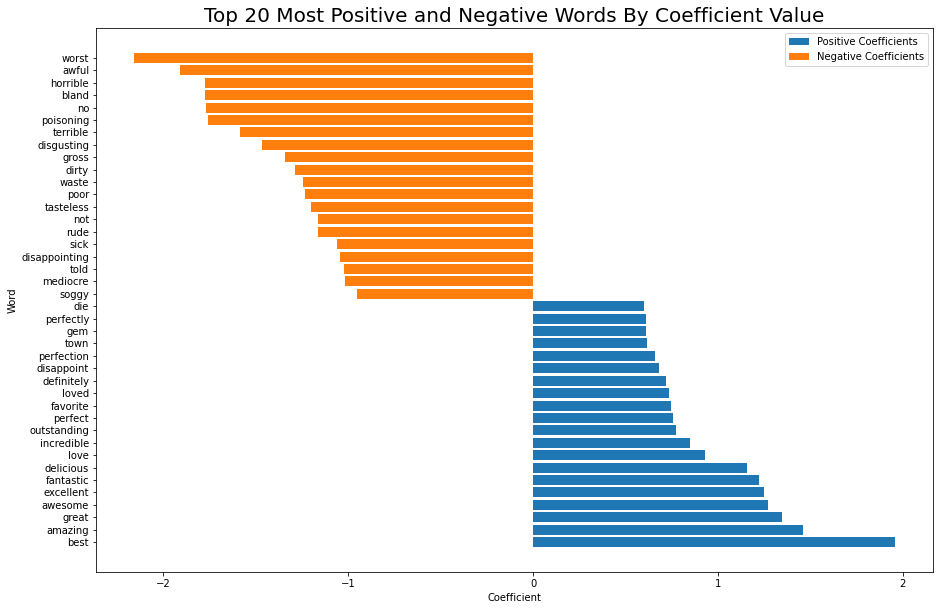

In [205]:
plt.figure(figsize=(15,10))
plt.title('Top 20 Most Positive and Negative Words By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.barh(review_coef_df['feature'].str.replace('tfidf_ct__', '').head(20),
         review_coef_df.head(20)["coefficient"], label='Positive Coefficients')
plt.barh(review_coef_df['feature'].str.replace('tfidf_ct__', '').tail(20),
         review_coef_df.tail(20)["coefficient"], label='Negative Coefficients')
plt.legend()

plt.show()

In [186]:
remaining_coef_df = coef_df[coef_df['feature'].str.contains('numeric__|category__')]
remaining_coef_df.head()

,feature,coefficient
42,numeric__repeat_customers,0.179457
41,numeric__reviews_per_week,0.164251
8,numeric__is_open,0.102958
33,numeric__Bakeries,0.083509
0,numeric__Year,0.074821


/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_4373/2236256158.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  plt.barh(remaining_coef_df['feature'].str.replace('numeric__|category__', '').head(20),
/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_4373/2236256158.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  plt.barh(remaining_coef_df['feature'].str.replace('numeric__|category__', '').tail(20),


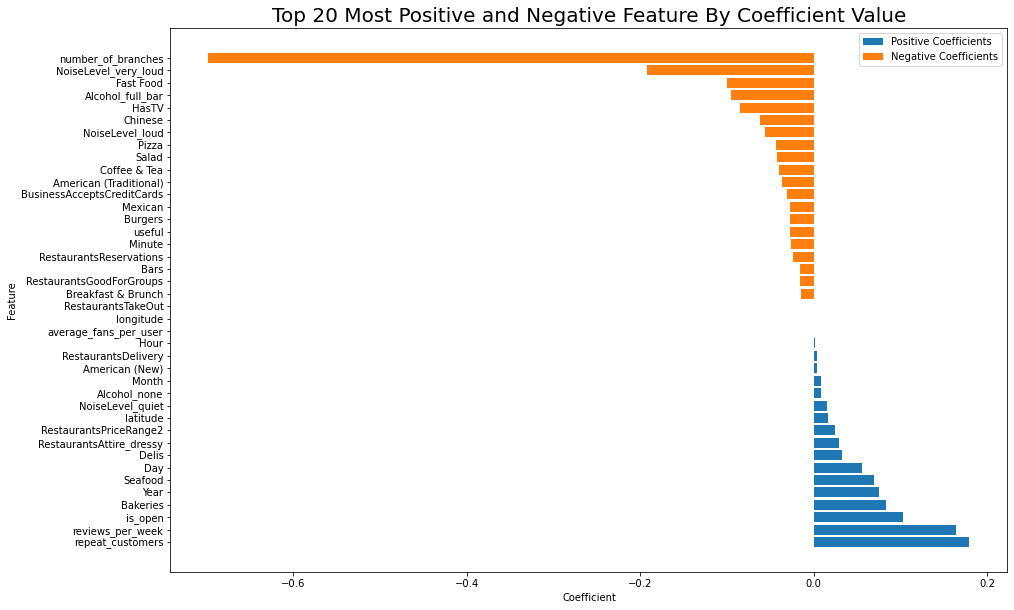

In [204]:
plt.figure(figsize=(15,10))
plt.title('Top 20 Most Positive and Negative Feature By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(remaining_coef_df['feature'].str.replace('numeric__|category__', '').head(20),
         remaining_coef_df.head(20)["coefficient"], label='Positive Coefficients')
plt.barh(remaining_coef_df['feature'].str.replace('numeric__|category__', '').tail(20),
         remaining_coef_df.tail(20)["coefficient"], label='Negative Coefficients')
plt.legend()

plt.show()

#### Saving the model

In [194]:
joblib.dump(best_linreg_pipeline, 'best_linreg_pipeline.pkl') 

['best_linreg_pipeline.pkl']

#### N-grams

In [486]:
tfidf_ngram_ct = define_col_trans('tfidf_ngram_ct',
                                   TfidfVectorizer(max_features=10000, ngram_range=(2,3),
                                                   stop_words='english'))

pipeline = Pipeline([
    ('col_trans', tfidf_ngram_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler())
])

In [487]:
%%time
X_train_prepared = pipeline.fit_transform(X_train)
X_train_prepared.shape

CPU times: user 5.19 s, sys: 780 ms, total: 5.97 s
Wall time: 5.99 s


(10918, 10052)

In [488]:
pipeline.named_steps['col_trans'].get_feature_names_out()

array(['numeric__Year', 'numeric__Month', 'numeric__Day', ...,
       'tfidf_ngram_ct__yummy food', 'tfidf_ngram_ct__zero stars',
       'tfidf_ngram_ct__ziti broccoli'], dtype=object)

In [489]:
ridge_reg = Ridge(alpha=10)

In [490]:
%%time

ridge_reg.fit(X_train_prepared, y_train)

CPU times: user 1min 55s, sys: 4.69 s, total: 2min
Wall time: 15.6 s


Ridge(alpha=10)

In [491]:
X_test_prepared = pipeline.transform(X_test)

In [492]:
# Print MAE and R-squared scores on both train and test sets

fitted_values = bound_predict(ridge_reg.predict(X_train_prepared))
print(f'MAE on train set: {round(custom_mae_scorer_func(y_train, fitted_values),2)} stars')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

print('\n')

fitted_values = bound_predict(ridge_reg.predict(X_test_prepared))
print(f'MAE on test set: {round(custom_mae_scorer_func(y_test, fitted_values),2)} stars')
print(f'R^2 on test set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set: 0.65 stars
R^2 on train set 0.64


MAE on test set: 0.8 stars
R^2 on test set 0.46


In [493]:
ngram_coef_df = pd.DataFrame({'feature': pipeline.named_steps['col_trans'].get_feature_names_out(),
                        'coefficient': ridge_reg.coef_}).\
                        sort_values("coefficient", ascending=False)
ngram_coef_df.head()

,feature,coefficient
4368,tfidf_ngram_ct__highly recommend,1.316622
5308,tfidf_ngram_ct__love place,1.231546
2910,tfidf_ngram_ct__food amazing,0.975562
1878,tfidf_ngram_ct__delicious food,0.909462
152,tfidf_ngram_ct__absolutely delicious,0.859532


In [494]:
review_coef_df = ngram_coef_df[ngram_coef_df['feature'].str.contains('tfidf_ngram_ct__')]
review_coef_df.head()

,feature,coefficient
4368,tfidf_ngram_ct__highly recommend,1.316622
5308,tfidf_ngram_ct__love place,1.231546
2910,tfidf_ngram_ct__food amazing,0.975562
1878,tfidf_ngram_ct__delicious food,0.909462
152,tfidf_ngram_ct__absolutely delicious,0.859532


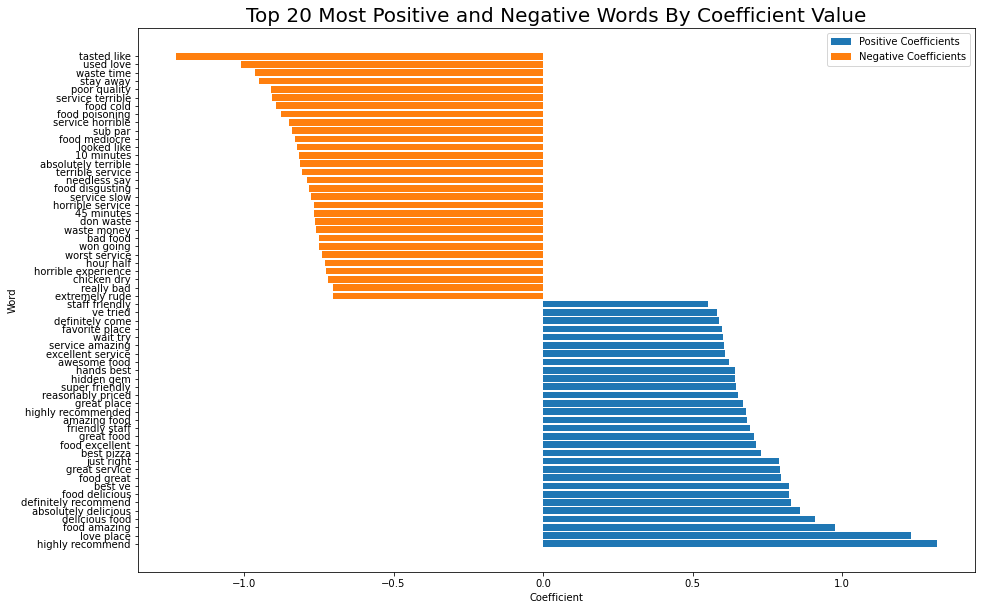

In [495]:
plt.figure(figsize=(15,10))
plt.title('Top 20 Most Positive and Negative Words By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.barh(review_coef_df['feature'].str.replace('tfidf_ngram_ct__', '').head(30),
         review_coef_df.head(30)["coefficient"], label='Positive Coefficients')
plt.barh(review_coef_df['feature'].str.replace('tfidf_ngram_ct__', '').tail(30),
         review_coef_df.tail(30)["coefficient"], label='Negative Coefficients')
plt.legend()

plt.show()

### Decision Trees

### Random Forests

### Gradient Boost

In [196]:
xgb_pipeline = Pipeline([
    ('col_trans', tfidf_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor())
])

param_grid = [{'model__max_depth': [6, 8, 10],
              'model__reg_lambda': [1, 10],
              'model__random_state': [0],   
              'model__n_estimators': [500],
              'model__learning_rate': [0.5]},
             {'model__max_depth': [6, 8, 10],
              'model__reg_lambda': [1, 10],
              'model__random_state': [0],   
              'model__n_estimators': [1000],
              'model__learning_rate': [0.1]}]

xgb_grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4, n_jobs=-1)

In [197]:
%%time
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 2/5] END model__learning_rate=0.5, model__max_depth=6, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.738) custom_r2_scorer: (test=0.503) total time=20.7min
[CV 3/5] END model__learning_rate=0.5, model__max_depth=8, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.728) custom_r2_scorer: (test=0.513) total time=26.8min
[CV 5/5] END model__learning_rate=0.5, model__max_depth=10, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.714) custom_r2_scorer: (test=0.492) total time=33.5min
[CV 2/5] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=1000, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (test=-0.661) custom_r2_scorer: (test=0.610) total time=41.1min
[CV 4/5] END model__learning_rate=0.1, model__max_depth=8, model__n_estimators=1000, model__

[CV 4/5] END model__learning_rate=0.5, model__max_depth=6, model__n_estimators=500, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (test=-0.695) custom_r2_scorer: (test=0.544) total time=21.3min
[CV 2/5] END model__learning_rate=0.5, model__max_depth=10, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.740) custom_r2_scorer: (test=0.491) total time=33.1min
[CV 3/5] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=1000, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.656) custom_r2_scorer: (test=0.618) total time=40.2min
[CV 5/5] END model__learning_rate=0.1, model__max_depth=8, model__n_estimators=1000, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.637) custom_r2_scorer: (test=0.616) total time=53.8min
[CV 2/5] END model__learning_rate=0.1, model__max_depth=10, model__n_estimators=1000, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (t

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

[CV 2/5] END model__learning_rate=0.5, model__max_depth=8, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.738) custom_r2_scorer: (test=0.496) total time=26.9min
[CV 3/5] END model__learning_rate=0.5, model__max_depth=10, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.743) custom_r2_scorer: (test=0.479) total time=33.7min
[CV 5/5] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=1000, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.636) custom_r2_scorer: (test=0.617) total time=40.4min
[CV 2/5] END model__learning_rate=0.1, model__max_depth=8, model__n_estimators=1000, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (test=-0.665) custom_r2_scorer: (test=0.603) total time=55.4min
[CV 4/5] END model__learning_rate=0.1, model__max_depth=10, model__n_estimators=1000, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (t

In [198]:
xgb_grid_search.best_score_


-0.6442711930639955

In [199]:
xgb_grid_search.best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 6,
 'model__n_estimators': 1000,
 'model__random_state': 0,
 'model__reg_lambda': 10}

In [201]:
best_xgb_pipeline = xgb_grid_search.best_estimator_

best_xgb_pipeline

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [202]:
%%time

best_xgb_pipeline.fit(X_train, y_train)

CPU times: user 55min 51s, sys: 10.8 s, total: 56min 2s
Wall time: 4min 58s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [203]:
# Print MAE and R-squared scores on both train and test sets

fitted_values = bound_predict(best_xgb_pipeline.predict(X_train))
print(f'MAE on train set: {round(custom_mae_scorer_func(y_train, fitted_values),2)} stars')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

print('\n')

fitted_values = bound_predict(best_xgb_pipeline.predict(X_test))
print(f'MAE on test set: {round(custom_mae_scorer_func(y_test, fitted_values),2)} stars')
print(f'R^2 on test set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set: 0.24 stars
R^2 on train set 0.94


MAE on test set: 0.63 stars
R^2 on test set 0.64


#### Saving the Model

In [496]:
joblib.dump(best_xgb_pipeline, 'best_xgb_pipeline.pkl') 

['best_xgb_pipeline.pkl']

In [207]:
pipeline = Pipeline([
    ('col_trans', tfidf_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler())
])

In [ ]:
X_train_prepared = pipeline.fit_transform(X_train)

In [210]:
X_train_prepared.shape

(10918, 2825)

In [215]:
xgb_reg = XGBRegressor(learning_rate = 0.1, max_depth = 6, verbosity = 1,
                      n_estimators = 1000, random_state = 0, reg_lambda = 0)


In [216]:
%%time

xgb_reg.fit(X_train_prepared, y_train)

CPU times: user 1h 7min 13s, sys: 57.2 s, total: 1h 8min 10s
Wall time: 6min 57s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [217]:
# Print MAE and R-squared scores on both train and test sets

fitted_values = bound_predict(xgb_reg.predict(X_train_prepared))
print(f'MAE on train set: {round(custom_mae_scorer_func(y_train, fitted_values),2)} stars')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

print('\n')

fitted_values = bound_predict(xgb_reg.predict(X_test_prepared))
print(f'MAE on test set: {round(custom_mae_scorer_func(y_test, fitted_values),2)} stars')
print(f'R^2 on test set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set: 0.22 stars
R^2 on train set 0.96


MAE on test set: 0.67 stars
R^2 on test set 0.59


## Rough Work

In [42]:
%%time

best_lin_reg_pipeline = grid_search.best_estimator_
best_lin_reg_pipeline.fit(X_train, y_train)

CPU times: user 9.26 s, sys: 620 ms, total: 9.88 s
Wall time: 2.07 s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [43]:
fitted_values = bound_predict(best_lin_reg_pipeline.predict(X_train))
print(f'MAE on train set {round(custom_mae_scorer_func(y_train, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')


MAE on train set 0.54
R^2 on train set 0.73


In [45]:
best_lin_reg_pipeline.named_steps['model'].coeff

Ridge(alpha=10)

In [52]:
#import dill
import joblib

joblib.dump(best_lin_reg_pipeline, 'best_lin_reg.pkl') 

['best_lin_reg.pkl']

In [184]:
best_lin_reg = joblib.load('best_lin_reg.pkl') 

In [185]:
fitted_values = bound_predict(best_lin_reg.predict(X_train))
print(f'MAE on train set {round(custom_mae_scorer_func(y_train, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

MAE on train set 0.54
R^2 on train set 0.73


In [186]:
fitted_values = bound_predict(best_lin_reg.predict(X_test))
print(f'MAE on test set {round(custom_mae_scorer_func(y_test, fitted_values),2)}')
print(f'R^2 on test set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set 0.63
R^2 on train set 0.64


In [187]:
best_lin_reg

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [ ]:
param_grid = [{'max_depth': [6, 10], 'max_features': [0.33, 0.66, 1.0], 'min_samples_leaf': [4, 6]}]

grid_search = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=1000, n_jobs=-2),
                           param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4)

## Word embeddings

In [55]:
import gensim

In [57]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    '../data/lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False
)

In [ ]:
from gensim.utils import simple_preprocess

def sentence2vec(text):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

In [ ]:
def sent2vec_col_trans(col):
    sentence_embedding = col.apply(sentence2vec)
    return np.array(sentence_embedding.tolist())

In [86]:
sent2vec_col_trans(X_train['text'])

array([[ 0.03598166, -0.02256804,  0.08554741, ..., -0.06141166,
        -0.0056973 , -0.02998764],
       [ 0.01424908,  0.01549971,  0.06497603, ..., -0.06388011,
        -0.00621364, -0.01018079],
       [ 0.02999975, -0.00643879,  0.07745692, ..., -0.08718176,
         0.03801628, -0.00418738],
       ...,
       [ 0.03231785,  0.01041096,  0.04757428, ..., -0.04298747,
         0.03416914, -0.0211182 ],
       [ 0.04077041, -0.03544312,  0.073274  , ..., -0.09089997,
         0.00019418, -0.06062922],
       [ 0.02808957,  0.02433967,  0.07809238, ..., -0.02453979,
        -0.00635034, -0.02454223]])

In [154]:
X_train_emb = X_train['text'].apply(sentence2vec)


In [155]:
X_train_emb

118838     [0.0359816570017886, -0.022568042987924336, 0....
984277     [0.014249082192242758, 0.015499712668091366, 0...
778602     [0.029999745458784238, -0.006438788229888174, ...
483464     [0.03688956283202226, -0.03194479993967848, 0....
496132     [0.04754691617563367, 0.008007916117397448, 0....
                                 ...                        
17442      [0.02793815035270094, -0.0049136734694827265, ...
1201057    [0.019272450373027022, 0.009937714227767224, 0...
1088320    [0.032317846082150936, 0.010410956383726284, 0...
1311295    [0.04077041218748566, -0.03544312414050717, 0....
910818     [0.02808957099127451, 0.02433967230669958, 0.0...
Name: text, Length: 10918, dtype: object

In [156]:
X_train_emb = np.array(X_train_emb.tolist())

In [157]:
X_train_emb

array([[ 0.03598166, -0.02256804,  0.08554741, ..., -0.06141166,
        -0.0056973 , -0.02998764],
       [ 0.01424908,  0.01549971,  0.06497603, ..., -0.06388011,
        -0.00621364, -0.01018079],
       [ 0.02999975, -0.00643879,  0.07745692, ..., -0.08718176,
         0.03801628, -0.00418738],
       ...,
       [ 0.03231785,  0.01041096,  0.04757428, ..., -0.04298747,
         0.03416914, -0.0211182 ],
       [ 0.04077041, -0.03544312,  0.073274  , ..., -0.09089997,
         0.00019418, -0.06062922],
       [ 0.02808957,  0.02433967,  0.07809238, ..., -0.02453979,
        -0.00635034, -0.02454223]])

In [158]:
csr_matrix(X_train_emb)

<10918x300 sparse matrix of type '<class 'numpy.float64'>'
	with 3273900 stored elements in Compressed Sparse Row format>

In [87]:
sent2vec = define_col_trans('sent2vec', FunctionTransformer(sent2vec_col_trans))
sent2vec


ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category', OneHotEncoder(drop='

In [108]:
pipeline = Pipeline([
    ('col_trans', sent2vec),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('min-max-scaler', MinMaxScaler()),
    ('model', Ridge())
])

In [109]:
param_grid = [
                {
                    'model__alpha': [0.001]
                }] 


grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4)

In [110]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__alpha=0.001; custom_mae_scorer: (test=-0.730) custom_r2_scorer: (test=0.528) total time=   7.7s
[CV 2/5] END model__alpha=0.001; custom_mae_scorer: (test=-0.741) custom_r2_scorer: (test=0.526) total time=   7.8s


KeyboardInterrupt: 

In [107]:
grid_search.best_score_

-0.6684598117186412

In [115]:
grid_search.best_params_

{'model__alpha': 0.001}

In [176]:
xgb_pipeline = Pipeline([
    ('col_trans', tfidf_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor(random_state=0, verbosity=1))
])

param_grid = [#{'max_depth': [6, 10], 'alpha': [0.1, 1, 10], 'n_estimators': [1000], 'learning_rate': [0.1]},
             {#'model__max_depth': [6],
              'model__reg_lambda': [10],
              'model__n_estimators': [500], 'model__learning_rate': [0.1]}]

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=3, n_jobs=-2)

In [177]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.714) custom_r2_scorer: (test=0.563) total time= 2.3min
[CV 5/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.681) custom_r2_scorer: (test=0.587) total time= 2.3min
[CV 1/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.696) custom_r2_scorer: (test=0.572) total time= 2.3min
[CV 3/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.706) custom_r2_scorer: (test=0.575) total time= 2.3min
CPU times: user 33min 7s, sys: 20 s, total: 33min 27s
Wall time: 13min 32s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

In [178]:
grid_search.best_score_

-0.6486781196677549

[CV 4/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.689) custom_r2_scorer: (test=0.581) total time= 2.3min
[CV 3/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.654) custom_r2_scorer: (test=0.617) total time=10.3min
[CV 2/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.668) custom_r2_scorer: (test=0.607) total time=10.4min
[CV 4/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.639) custom_r2_scorer: (test=0.622) total time=10.4min
[CV 5/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.638) custom_r2_scorer: (test=0.617) total time=10.4min
[CV 1/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.644) custom_r2_scorer: (test=0.615) total

In [179]:
xgb_best = grid_search.best_estimator_

In [181]:
%%time

xgb_best.fit(X_train, y_train)

CPU times: user 33min 19s, sys: 16.2 s, total: 33min 35s
Wall time: 3min 5s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [182]:
fitted_values = bound_predict(xgb_best.predict(X_train))
print(f'MAE on train set {round(custom_mae_scorer_func(y_train, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

MAE on train set 0.34
R^2 on train set 0.88


In [183]:
fitted_values = bound_predict(xgb_best.predict(X_test))
print(f'MAE on train set {round(custom_mae_scorer_func(y_test, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set 0.63
R^2 on train set 0.63


In [188]:
xgb_pipeline = Pipeline([
    ('col_trans', tfidf_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor(random_state=0, verbosity=1))
])

param_grid = [#{'max_depth': [6, 10], 'alpha': [0.1, 1, 10], 'n_estimators': [1000], 'learning_rate': [0.1]},
             {#'model__max_depth': [6],
              'model__reg_lambda': [100],
              'model__n_estimators': [500], 'model__learning_rate': [0.1]}]

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=3, n_jobs=-2)

In [189]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 33min 3s, sys: 26.7 s, total: 33min 29s
Wall time: 13min 58s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

[CV 4/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.639) custom_r2_scorer: (test=0.626) total time=10.6min
[CV 2/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.657) custom_r2_scorer: (test=0.619) total time=10.6min
[CV 5/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.636) custom_r2_scorer: (test=0.627) total time=10.6min
[CV 3/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.647) custom_r2_scorer: (test=0.626) total time=10.6min
[CV 1/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.641) custom_r2_scorer: (test=0.615) total time=10.6min


In [191]:
xgb_best = grid_search.best_estimator_

In [192]:
%%time

xgb_best.fit(X_train, y_train)

CPU times: user 33min 47s, sys: 17.9 s, total: 34min 5s
Wall time: 3min 7s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [193]:
fitted_values = bound_predict(xgb_best.predict(X_train))
print(f'MAE on train set {round(custom_mae_scorer_func(y_train, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

MAE on train set 0.42
R^2 on train set 0.83


In [194]:
fitted_values = bound_predict(xgb_best.predict(X_test))
print(f'MAE on train set {round(custom_mae_scorer_func(y_test, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set 0.64
R^2 on train set 0.63


In [200]:
print(xgb_best.get_params()['model'].feature_importances_)

[6.8482987e-05 5.2745261e-05 1.0994075e-04 ... 4.3695117e-04 0.0000000e+00
 0.0000000e+00]


In [202]:
from xgboost import plot_importance

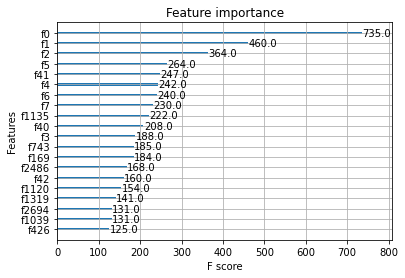

In [204]:
plot_importance(xgb_best.get_params()['model'], max_num_features=20)
plt.show()